# Generative Model (Juices dataset)

In [20]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.7


## Load raw data and plot

In [21]:
# read .csv file into Dataframe
data = pd.read_csv('../../data/juices/FTIR_juices.csv')
data.head(5)

,899.327,903.187,907.047,910.907,914.767,918.627,922.487,926.347,930.207,934.067,...,1771.684,1775.544,1779.404,1783.264,1787.124,1790.984,1794.844,1798.704,1802.564,label
0,0.002806,0.002732,0.002661,0.002657,0.002699,0.002762,0.002749,0.002686,0.002637,0.002617,...,0.000348,0.000216,0.000166,0.000117,0.000087,0.000046,0.000011,0.000009,0.000009,NON-Strawberry
1,0.002637,0.002638,0.002651,0.002757,0.003000,0.003313,0.003412,0.003302,0.003162,0.003060,...,0.000013,0.000006,-0.000005,-0.000005,-0.000006,0.000002,0.000010,0.000005,0.000005,NON-Strawberry
2,0.002416,0.002480,0.002511,0.002611,0.002802,0.003031,0.003235,0.003316,0.003257,0.003136,...,0.000290,0.000185,0.000137,0.000090,0.000062,0.000031,0.000009,0.000007,0.000007,NON-Strawberry
3,0.002345,0.002292,0.002249,0.002303,0.002466,0.002642,0.002703,0.002671,0.002618,0.002567,...,0.000419,0.000267,0.000179,0.000119,0.000075,0.000043,0.000021,0.000008,0.000008,NON-Strawberry
4,0.002303,0.002342,0.002350,0.002419,0.002561,0.002737,0.002862,0.002860,0.002811,0.002750,...,0.000468,0.000299,0.000212,0.000140,0.000099,0.000054,0.000020,0.000012,0.000012,NON-Strawberry


In [22]:
# shuffle data rows
data = data.sample(frac=1, random_state=42)

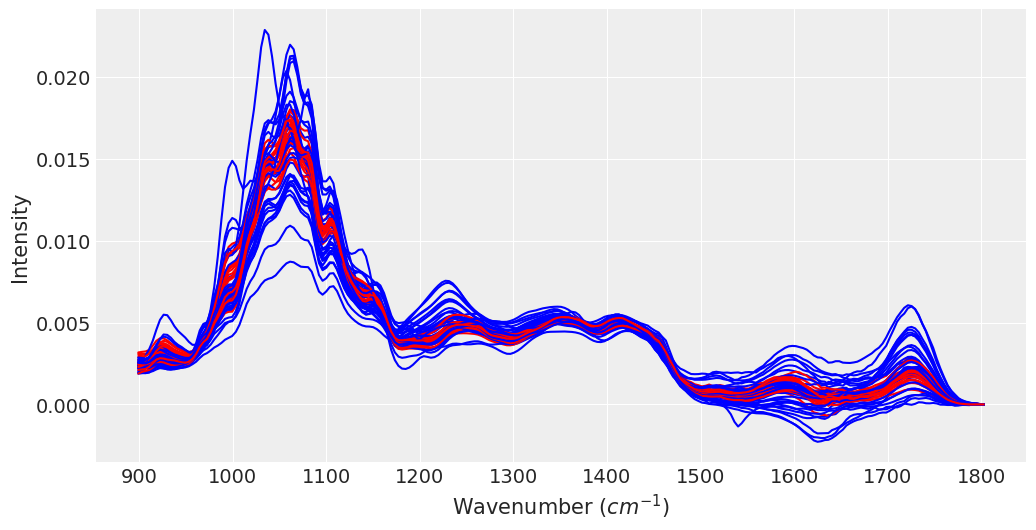

In [23]:
# number of non-data columns at right of dataframe
ndata_cols = -1

# header data = x-values
cols = data.columns.to_list()
x_val = np.array(cols[:ndata_cols], dtype='float32')

# plot all data in 1 figure
fig = plt.figure(figsize=(12,6))
ax = plt.axes()
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.set(xlabel='Wavenumber ($cm^{-1}$)', ylabel='Intensity')

for i in range(50):
    y_val = data.values[i]
    if y_val[-1] == 'NON-Strawberry':
        col = 'blue'
    else:
        col = 'red'
    plt.plot(x_val, y_val[:ndata_cols], '-', color=col);

In [24]:
data.describe()

,899.327,903.187,907.047,910.907,914.767,918.627,922.487,926.347,930.207,934.067,...,1767.824,1771.684,1775.544,1779.404,1783.264,1787.124,1790.984,1794.844,1798.704,1802.564
count,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,...,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000
mean,0.002450,0.002465,0.002495,0.002604,0.002811,0.003044,0.003176,0.003174,0.003096,0.002994,...,0.000313,0.000218,0.000139,0.000092,0.000062,0.000041,0.000029,0.000019,0.000009,0.000008
std,0.000342,0.000351,0.000383,0.000428,0.000495,0.000596,0.000710,0.000792,0.000790,0.000718,...,0.000211,0.000159,0.000122,0.000100,0.000078,0.000059,0.000039,0.000026,0.000011,0.000011
min,0.001391,0.001389,0.001371,0.001472,0.001585,0.001667,0.001738,0.001754,0.001791,0.001836,...,-0.000069,-0.000073,-0.000061,-0.000050,-0.000049,-0.000084,-0.000023,-0.000055,-0.000014,-0.000014
25%,0.002227,0.002226,0.002239,0.002313,0.002478,0.002642,0.002684,0.002633,0.002554,0.002505,...,0.000174,0.000118,0.000067,0.000038,0.000023,0.000014,0.000013,0.000007,0.000004,0.000002
50%,0.002449,0.002469,0.002494,0.002592,0.002779,0.002969,0.003054,0.003025,0.002948,0.002856,...,0.000279,0.000192,0.000116,0.000074,0.000048,0.000031,0.000022,0.000014,0.000008,0.000007
75%,0.002711,0.002728,0.002776,0.002916,0.003165,0.003427,0.003590,0.003601,0.003502,0.003362,...,0.000412,0.000286,0.000183,0.000121,0.000079,0.000058,0.000036,0.000024,0.000012,0.000011
max,0.003317,0.003450,0.003648,0.003943,0.004506,0.005230,0.005935,0.006418,0.006391,0.005979,...,0.001555,0.001495,0.001423,0.001319,0.001122,0.000889,0.000644,0.000380,0.000187,0.000187


In [25]:
# number of samples from each class
data['label'].value_counts()

NON-Strawberry    632
Strawberry        351
Name: label, dtype: int64

In [26]:
# store data values for class A and B
df_a = data.query("label == ('NON-Strawberry')")
df_b = data.query("label == ('Strawberry')")

x_n = data.columns[:ndata_cols]

x_sa = df_a[x_n].values
x_sb = df_b[x_n].values

x_sa.shape

(632, 235)

# Model definition

The following model is assumed:

\begin{equation}
\mu_{m} \sim \text{LogNormal}(0, 1) \\
\sigma_{ab} \sim \Gamma(1, 1) \\
\sigma_{m} \sim |\mathcal{N}(0, \sigma^{2}_{ab})| \\
\mu \sim \mathcal{N}(\mu_{m},\sigma^{2}_{m}) \\
\sigma_{\sigma} \sim \Gamma(1, 1) \\
\sigma \sim |\mathcal{N}(0, \sigma^{2}_{\sigma})| \\
X_{a,b} \sim \mathcal{N}(\mu,\sigma^{2})
\end{equation}

In [27]:
# number of classes in data
nclass = 2

# number of examples used for training
ntrain = 30

with pm.Model() as model_gm:
    
    mu_m = pm.Lognormal('mu_m', mu=0, sigma=1) 
    sigma_ab = pm.Gamma('sigma_ab', alpha=1., beta=1.)
    sigma_mu = pm.HalfNormal('sigma_mu', sigma_ab)
    mu = pm.Normal('mu', mu=mu_m, sd=sigma_mu, shape=(nclass,len(x_n)))
    
    sigma_s = pm.Gamma('sigma_s', alpha=1., beta=1.)
    sigma = pm.HalfNormal('sigma', sigma_s)
    
    class_a = pm.Normal('class_a', mu=mu[0], sd=sigma, observed=x_sa[:ntrain])
    class_b = pm.Normal('class_b', mu=mu[1], sd=sigma, observed=x_sb[:ntrain])
    
    trace_gm = pm.sample(2000, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, sigma_s, mu, sigma_mu, sigma_ab, mu_m]
Sampling 2 chains: 100%|██████████| 5000/5000 [01:45<00:00, 47.44draws/s] 
The acceptance probability does not match the target. It is 0.9565594642414286, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9217456019914837, but should be close to 0.8. Try to increase the number of tuning steps.


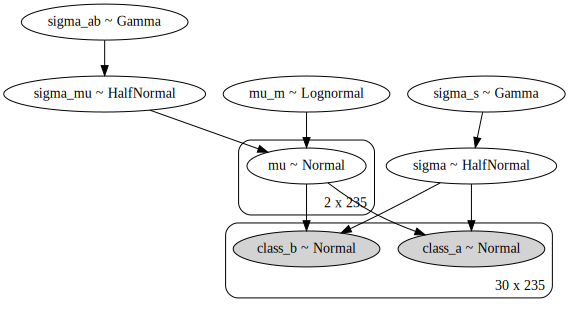

In [28]:
pm.model_to_graphviz(model_gm)

In [29]:
az.summary(trace_gm)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"mu[0,0]",0.002,0.000,0.002,0.003,0.000,0.000,6339.0,6323.0,6351.0,2673.0,1.0
"mu[0,1]",0.002,0.000,0.002,0.003,0.000,0.000,6841.0,6841.0,6771.0,2406.0,1.0
"mu[0,2]",0.002,0.000,0.002,0.003,0.000,0.000,5683.0,5621.0,5700.0,2237.0,1.0
"mu[0,3]",0.003,0.000,0.002,0.003,0.000,0.000,5621.0,5621.0,5609.0,2884.0,1.0
"mu[0,4]",0.003,0.000,0.002,0.003,0.000,0.000,7624.0,7509.0,7614.0,2760.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
mu_m,0.004,0.000,0.004,0.005,0.000,0.000,6885.0,6885.0,6871.0,3069.0,1.0
sigma_ab,0.204,0.413,0.001,0.831,0.008,0.006,2784.0,2784.0,3740.0,2830.0,1.0
sigma_mu,0.004,0.000,0.004,0.004,0.000,0.000,5471.0,5456.0,5464.0,2892.0,1.0
sigma_s,0.152,0.344,0.000,0.689,0.006,0.004,3456.0,3456.0,4640.0,3634.0,1.0


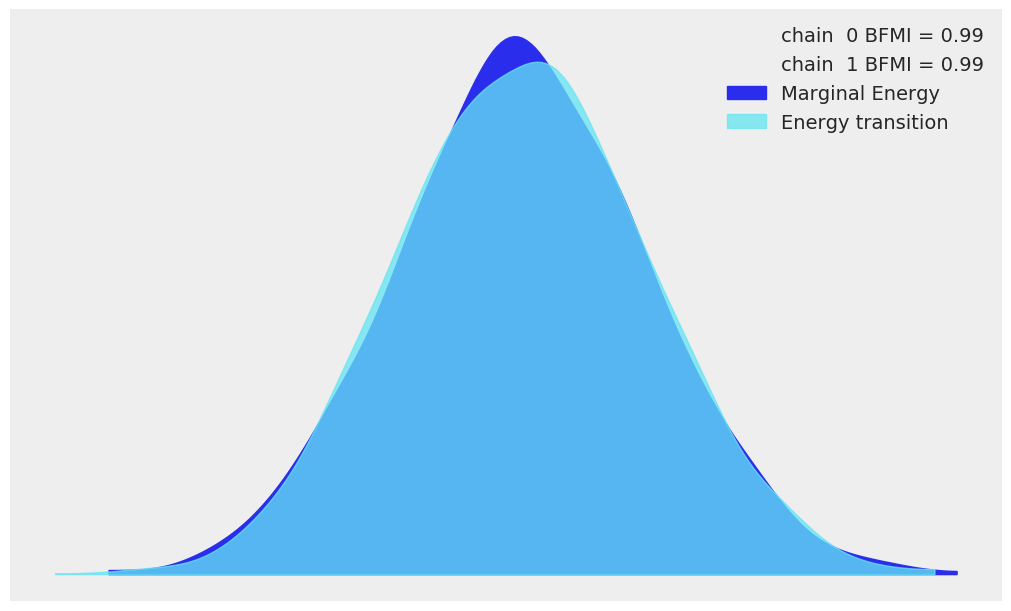

In [30]:
az.plot_energy(trace_gm, figsize=(10, 6));

In [31]:
ppc = pm.sample_posterior_predictive(trace_gm, samples=250, model=model_gm)

100%|██████████| 250/250 [00:01<00:00, 213.79it/s]


arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


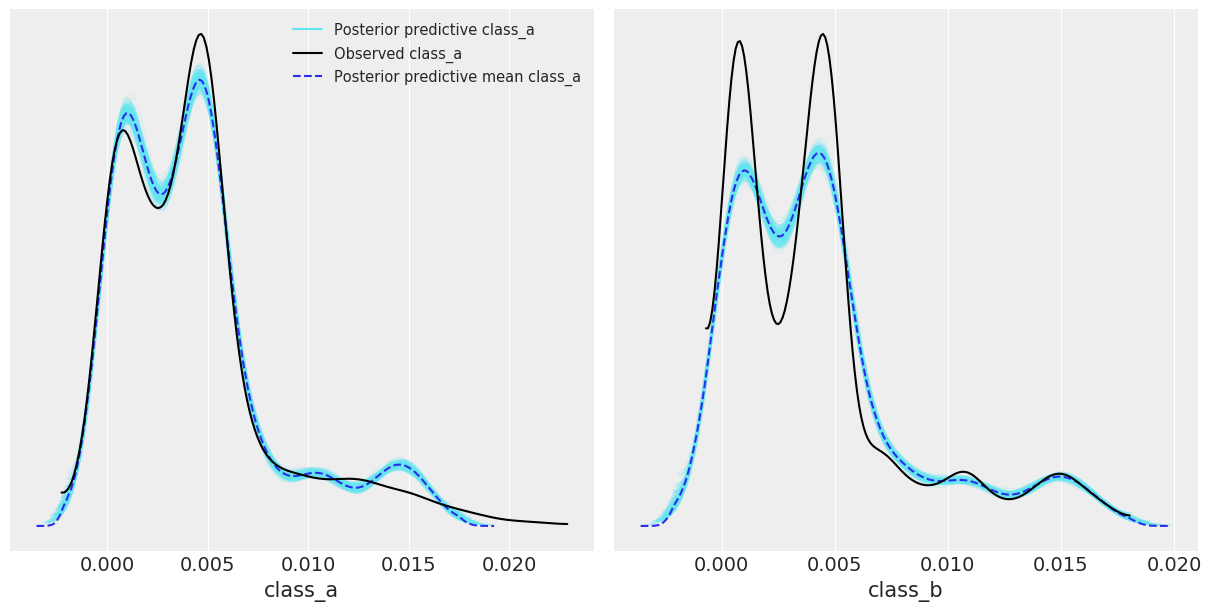

In [32]:
data_ppc = az.from_pymc3(trace=trace_gm, posterior_predictive=ppc)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)

In [33]:
print(az.r2_score(x_sa[:ntrain], ppc['class_a']))

r2        0.952894
r2_std    0.004044
dtype: float64


In [34]:
print(az.r2_score(x_sb[:ntrain], ppc['class_b']))

r2        0.956245
r2_std    0.003745
dtype: float64


In [35]:
print(az.bfmi(trace_gm))

[0.98815024 0.98749021]


# Posterior samples vs. mean data

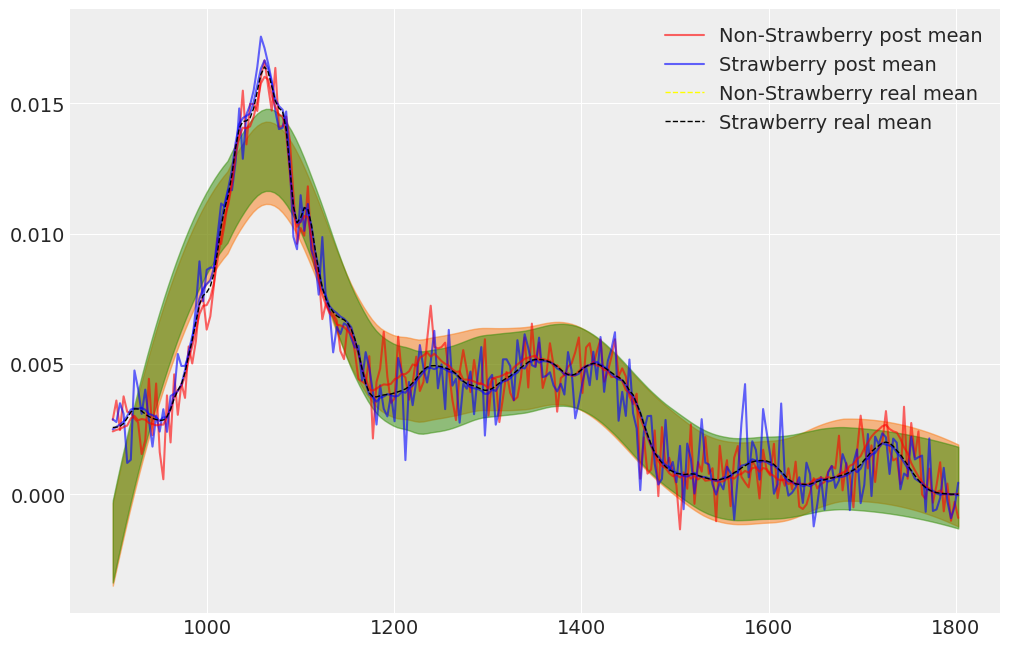

In [40]:
# draw class samples from the posterior
cl_a = ppc['class_a']
cl_b = ppc['class_b']

# get header data = x-values
cols = data.columns.to_list()
x_val = np.array(cols[:ndata_cols], dtype='float32')

fig = plt.figure(figsize=(12,8))
ax = plt.axes()

# plot some samples from the posterior
for i in range(1):
    plt.plot(x_val, cl_a[i,0,:], '-', color="red", alpha=.6)
    plt.plot(x_val, cl_b[i,0,:], '-', color="blue", alpha=.6)

# plot the posterior mean
plt.plot(x_val, cl_a[:,0].mean(axis=0), '-', color="red", alpha=.6, label='Non-Strawberry post mean')
plt.plot(x_val, cl_b[:,0].mean(axis=0), '-', color="blue", alpha=.6, label='Strawberry post mean')

# plot mean data for classes (raw data)
df1 = data.loc[data['label'] == 'Non-Strawberry']
df2 = data.loc[data['label'] == 'Strawberry']

plt.plot(x_val, df1.iloc[:,:ndata_cols].mean(), '--', color='yellow', 
         label='Non-Strawberry real mean', linewidth=1)
plt.plot(x_val, df2.iloc[:,:ndata_cols].mean(), '--', color='black', 
         label='Strawberry real mean', linewidth=1)

# plot 95% HPD interval
az.plot_hpd(x_val, ppc['class_a'], color='C1')
az.plot_hpd(x_val, ppc['class_b'], color='C2')

plt.legend(loc='best');

# Real spectrum vs. posterior samples

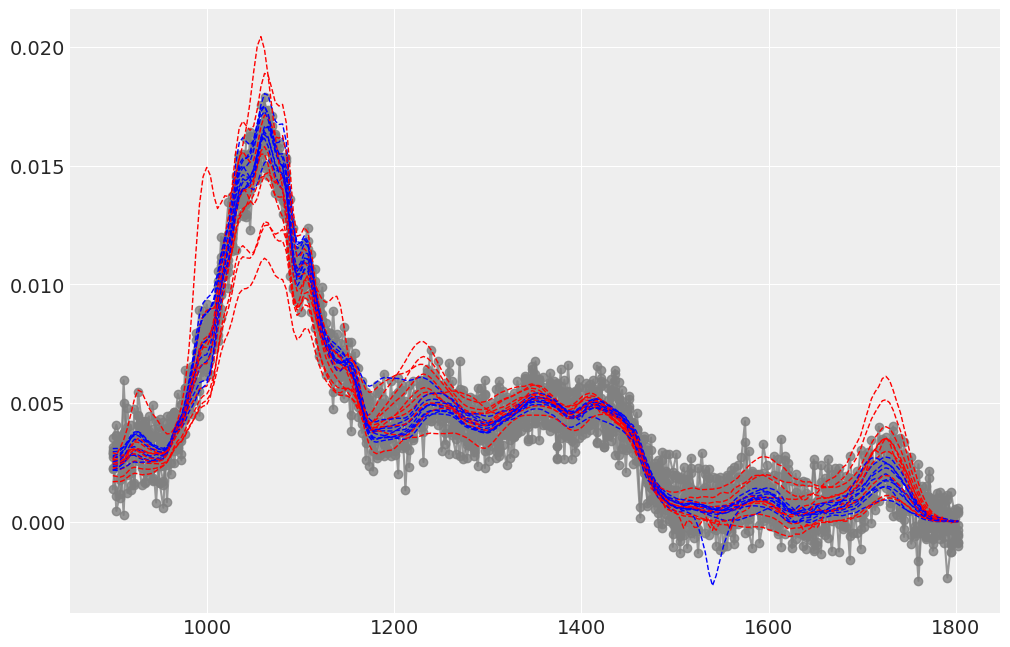

In [39]:
fig = plt.figure(figsize=(12,8))
ax = plt.axes()

# plot some samples from the posterior
for i in range(5):
    plt.plot(x_val, cl_a[i,0,:], 'o-', color="gray", alpha=.8)
    plt.plot(x_val, cl_b[i,0,:], 'o-', color="gray", alpha=.8)

# plot mean data for classes (raw data)
df1 = data.loc[data['label'] == 'NON-Strawberry'].sample(frac=1)
df2 = data.loc[data['label'] == 'Strawberry'].sample(frac=1)
    
for i in range(10):
    plt.plot(x_val, df1.values[i,:ndata_cols], '--', color='red', linewidth=1)
    plt.plot(x_val, df2.values[i,:ndata_cols], '--', color='blue', linewidth=1)